In [8]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.ticker import MultipleLocator

matplotlib.rcParams['legend.handlelength'] = 1
matplotlib.rcParams['legend.handleheight'] = 1

METHODS = ['dft', 'emle', 'mm']
SYSTEMS = ['enzyme', 'enzyme2']

ERRORS = {'dft':  {'enzyme':  {'TS': 0.6, 'P': 1.1},
                   'enzyme2': {'TS': 0.9, 'P': 3.5}},
          'emle': {'enzyme':  {'TS': 0.8, 'P': 0.8},
                   'enzyme2': {'TS': 0.9, 'P': 1.5}},
          'mm':   {'enzyme':  {'TS': 0.7, 'P': 1.7},
                   'enzyme2': {'TS': 0.8, 'P': 3.3}}}

plt.rc('figure', facecolor='w')

In [9]:
def read_pmf(system, method):
    return np.loadtxt(f'ABYU/PMF/pmf_{system}_{method}.dat').T

def read_method_bar(method, systems):
    pmfs_raw = np.array([read_pmf(system, method)[1] for system in systems]) 
    pmfs = pmfs_raw - np.min(pmfs_raw[:,pmfs_raw.shape[1]//2:], axis=1, keepdims=True)

    errors = ERRORS[method]

    return {system: {'TS': np.max(pmf), 
                     'eTS': errors[system]['TS'],
                     'P': np.min(pmf),
                     'eP': errors[system]['P']} 
            for system, pmf in zip(systems, pmfs)}

def read_method_pmf(method, systems):
    data_raw = np.array([read_pmf(system, method) for system in systems])
    rc = data_raw[0][0]
    pmfs_raw = data_raw[:,1,:]
    pmfs = pmfs_raw - np.min(pmfs_raw[:,len(rc)//2:], axis=1, keepdims=True)
    return {'rc': rc, **{system: pmf for system, pmf in zip(systems, pmfs)}}
    

all_bar_data = {method: read_method_bar(method, SYSTEMS) for method in METHODS}
all_pmf_data = {method: read_method_pmf(method, SYSTEMS) for method in METHODS}

In [10]:
PALETTE = {'black': '#000000', 
           'orange': '#ff7f0e',
           'blue': '#1f77b4', }

COLORS = {'enzyme': PALETTE['blue'], 'enzyme2': PALETTE['orange']}

LINESTYLES = {'emle': '-', 'mm': ':', 'dft': '-'}
LABELS = {'enzyme': 'Pose 1', 
          'enzyme2': 'Pose 2',
          'dft': 'DFT/MM',
          'emle': 'ML(EMLE)/MM',
          'mm': 'MM embedding'}

def plot_pmf(ax, data, method):
    for system in SYSTEMS:
        ax.plot(data[method]['rc'], 
                data[method][system], 
                c=COLORS[system], 
                linestyle=LINESTYLES[method],
                linewidth=2 if method == 'dft' else None,
                label=f'{LABELS[system]} {LABELS[method]}')

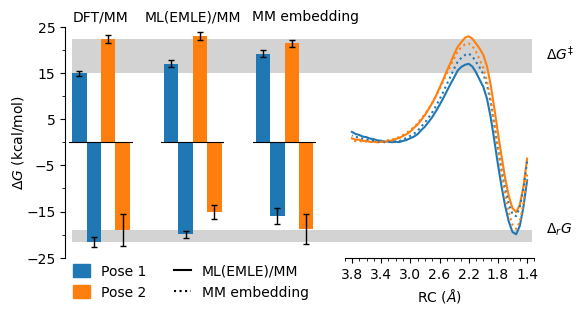

In [18]:
fig, axs = plt.subplot_mosaic([['dft', 'emle', 'mm', 'pmf']], 
                              figsize=(6, 3), 
                              gridspec_kw={'wspace': 0.3, 'width_ratios': [0.1, 0.1, 0.1, 0.3]})

for name, ax in axs.items():

    ax.set_ylim([-25,25])
    ax.set_facecolor('none')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if name == 'pmf':
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_visible(False)
        
        plot_pmf(ax, all_pmf_data, 'emle')
        plot_pmf(ax, all_pmf_data, 'mm')
        
        ax.set_xlabel('RC ($\AA$)')
        ax.set_xlim([1.3, 3.9])
        ax.set_xticks(np.arange(1.4, 3.8 + 0.1, 0.4))
        ax.xaxis.set_minor_locator(MultipleLocator(0.1))
        ax.spines['bottom'].set_position(('data', -25))
        ax.invert_xaxis()
        continue

    method = name
    data = all_bar_data[method]

    ax.axhline(y=0, color='black', linewidth=0.8)
    ax.spines['bottom'].set_visible(False)    

    error_kw = {'elinewidth': 1, 'capthick': 1, 'color': 'black'}
    for i, system in enumerate(SYSTEMS):
        ax.bar(i + 0.5, data[system]['TS'], yerr=data[system]['eTS'], 
               capsize=2, error_kw=error_kw, width=0.5, color=COLORS[system])
        ax.bar(i + 1., data[system]['P'], yerr=data[system]['eP'], 
               capsize=2, error_kw=error_kw, width=0.5, color=COLORS[system])
    
    ax.set_xticks([])

    if method == 'dft':
        ax.spines['left'].set_position(('data', 0))
        ax.set_ylabel('$\Delta G$ (kcal/mol)', rotation=90, labelpad=0)
        ax.set_yticks(np.arange(-25, 26, 10))
        ax.yaxis.set_minor_locator(MultipleLocator(5))
    else:
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_visible(False)

legend_items = []
for system in SYSTEMS:
    legend_items.append(
        mpatches.Patch(color=COLORS[system], label=LABELS[system])
    )
for method in ['emle', 'mm']:
    legend_items.append(Line2D([0], [0], color='black', linestyle=LINESTYLES[method], label=LABELS[method]))

TOP_TEXT_Y = 0.9
fig.text(0.13, TOP_TEXT_Y, 'DFT/MM')
fig.text(0.25, TOP_TEXT_Y, 'ML(EMLE)/MM')
fig.text(0.43, TOP_TEXT_Y, 'MM embedding')

RIGHT_LABELS_X = 0.92
fig.text(RIGHT_LABELS_X, 0.77, '$\Delta G^{\ddagger}$')
fig.text(RIGHT_LABELS_X, 0.19, '$\Delta_r G$')

dft_enzyme = all_bar_data['dft']['enzyme']
dft_enzyme2 = all_bar_data['dft']['enzyme2']

rect_ts = mpatches.Rectangle(
    (0.25, dft_enzyme['TS']),
    16,
    dft_enzyme2['TS'] - dft_enzyme['TS'],
    transform=axs['dft'].transData,
    color='lightgray',
    alpha=1.,
    linewidth=0,
    zorder=-1
)
fig.patches.append(rect_ts)

rect_p = mpatches.Rectangle(
    (0.25, dft_enzyme['P']),
    16,
    dft_enzyme2['P'] - dft_enzyme['P'],
    transform=axs['dft'].transData,
    color='lightgray',
    alpha=1.,
    linewidth=0,
    zorder=-1
)
fig.patches.append(rect_p)

fig.legend(handles=legend_items, handlelength=1.2, loc='lower center', bbox_to_anchor=(0.328, -0.07), ncol=2, frameon=False)
plt.savefig('Fig3.png', dpi=300, bbox_inches='tight')
            
plt.show()